# RCFGL Workflow

### Loading the required modules

- We load the existing modules, "pandas", "sys", and "StandardScaler" function from the module, "sklearn.preprocessing".

- We load two functions, "RFGL" and "RCFGL" for fitting the respective models from our module named "RCFGL".

- We also load a couple of functions for downstream analysis, from our module named "Dstream_functions".

- Replace '/Users/seals/Documents/GitHub' from the following section by the address of the repository in your         system.

In [1]:
import pandas as pd
import sys
from sklearn.preprocessing import StandardScaler

sys.path.insert(0, '/Users/seals/Documents/GitHub/RCFGL/Python_functions')
from RCFGL import RFGL, RCFGL
from Dstream_functions import*

### Data description and loading

In the following example, we consider gene-expression data from three different conditions ($K = 3$), all having the same number of genes ($p = 500$) and the same number of samples ($n = 100$). Note that, in the RCFGL model, the sample size per condition ($n_k$) is allowed to vary but the number of genes has to be the same across $K$ conditions. Here, the true networks of the conditions 1 and 2 were excatly the same, whereas the true network of the condition 3 was only partially same with the other two. Please refer to scenario (S1) of the original manuscript for further data description.

The datafiles are provided ihe "Data" folder of the repository and can be loaded in dataframe format ($n \times p$) as follows.


In [2]:
B = pd.read_csv('/Users/seals/Documents/GitHub/RCFGL/Data/Data_1.csv');
H = pd.read_csv('/Users/seals/Documents/GitHub/RCFGL/Data/Data_2.csv');
M = pd.read_csv('/Users/seals/Documents/GitHub/RCFGL/Data/Data_3.csv');

### Final formatting of the data

- The dataframes need to be mean ceneterd i.e., all of the $p$ columns must have mean 0. We use the "StandardScaler" function from the module "sklearn.preprocessing" for that purpose. If the dataframes are already mean scaled upon loading, one can ignore this preprocessing step. 

- We append the three different dataframes, B, H and M together to create a combined list of dataframes named A.

- In both RFGL and RCFGL,

In [3]:
# Scaling the dataframes such that the columns have 0 mean
scalerB = StandardScaler(with_std=False); scalerB.fit(B)
B = scalerB.transform(B)

scalerH = StandardScaler(with_std=False);  scalerH.fit(H)
H = scalerH.transform(H)

scalerM = StandardScaler(with_std=False); scalerM.fit(M)
M = scalerM.transform(M)

# Combined list of the scaled dataframes
A = []; A.append(B); A.append(H); A.append(M);

### Setting the parameters

- The two main parameters for fitting RFGL or RCFGL are the penalty parameters, $\lambda_1$ and $\lambda_2$. The former controls the overall sparsity, whereas the latter controls the level of similarity across different conditions. For both RFGL and RCFGL, we recommend trying different sets of $(\lambda_1, \lambda_2)$ and choose the one which is the most interpretable. Otherwise, one can choose the set of $(\lambda_1, \lambda_2)$ that achieves the lowest AIC. (AIC is reported as an output along with the estimated networks by our functions.)

- There are other parameters which control the ADMM algorithm in the backend and may ocassionally need tuning. The most relevant ones are, 
  1. The maximum number of iterations, "ADMMmaxiter", default is 100, The algorithm will run for a maximum of 100 iterations if not converged early.
  2. Stopping criterion, "admmtol", default is $0.001$. The algorithm will stop if the change in relative $L^1$ norm between the estimated precision matrices of two consecutibve iterations is less than $0.001$.
<!--   3. Truncating small elements, "truncate", default is $0.0001$. Set the elements of the estimated precision matrices having absolute value less than 0.0001 to 0. -->

### Fitting RFGL

We first fit the RFGL model using our function "RFGL". The main arguments of "RFGL" are lambda1 ($\lambda_1$), lambda2 ($\lambda_2$), A (list of the scaled dataframes), ADMMmaxiter and admmtol which have been earlier defined.

In [4]:
RFGL_output = RFGL(lambda1 = 0.1, lambda2 = 0.1, A = A, ADMMmaxiter = 100, admmtol = 0.001)

### Fitting RCFGL


Next, we fit the RCFGL mode using our function "RCFGL". "RCFGL" takes the same arguments as "RFGL".
<!-- We compute (K-1) many weight matrices (stored in array Weight[k]) corresponding to category pair (k, k+1) for k = 1,..., (K-1). The $ij$-th element of the matrix Weight[k] can only be 1 or 0.  We also construct two tuples: which_K (stores $ij$ locations where all the matrices Weight[k], for k = 1,..., (K-1) have value 1) and which_not_K (stores $ij$ locations where at least one of the matrices Weight[k] does not have value 1). -->

In [5]:
RCFGL_output = RCFGL(lambda1 = 0.1, lambda2 = 0.1, A = A, ADMMmaxiter = 100, admmtol = 0.001)

### Structure of the output

For both RFGL and RCFGL, the output has a similar structure. The output is a list of three objects,
 1. Estimated precision matrices of all the $K$ conditions as a numpy array of dimension $p \times p \times K$,
 2. AIC of the fitted model, and 
 3. Time taken to fit the model.

### Extracting the results

Next, we discuss how to extract and interpret the results. We will focus on "RCFGL_output".


#### Create adjacency matrices

- To create the adjacency matrices we use our function "MakeAdjMatrix_all". It creates and stores the adjacency matrices of all the $K$ conditions in pandas dataframe format one after another i.e., the first adjacency matrix corresponds to the condition 1 and the third adjacency matrix corresponds to the condition 3.

- The function takes the earlier output object (RFGL_output or RCFGL_output) as one of the inputs along with two other arguments, "truncation_value" and "top_N".  

- "truncation_value" is used to define an edge, e.g., the default option, "truncation_value = 0.05" implies if the absolute value of the $(i, j)$-th off-diagonal element of the $k$-th precision matrix is more than 0.05, an edge will be drawn between them (in other words, the corresponding element of the adjacency matrix will be set to 1).

- "top_N" is used to specify how many top nodes we want to detect, e.g., "top_N = 75" gives us top 75 edges based on the estimated weights i.e., the absolute values of the off-diagonal elements of the precision matrices. The default option, "top_N = 'all'" would give us the full network. For better visualization purpose, we recommend using smaller "top_N".

- To specify the gene names, we can provide a vector of names of length $p$. The default is "names = 'default'" which considers the names of $p$ genes to be $0, 1,...,p-1.$

In [6]:
Adjacency_all = MakeAdjMatrix_all(RCFGL_output, truncation_value = 0.05, top_N = 75, names = 'default')

#### Plot the network of one condition

We provide a function named "NetworkPlotter" to display the network of a particular condition. The function takes the list of adjacency matrices, "Adjacency_all" and the condition of interest, "which" as arguments. For example, in the plot below, we display the network of the condition 2. 

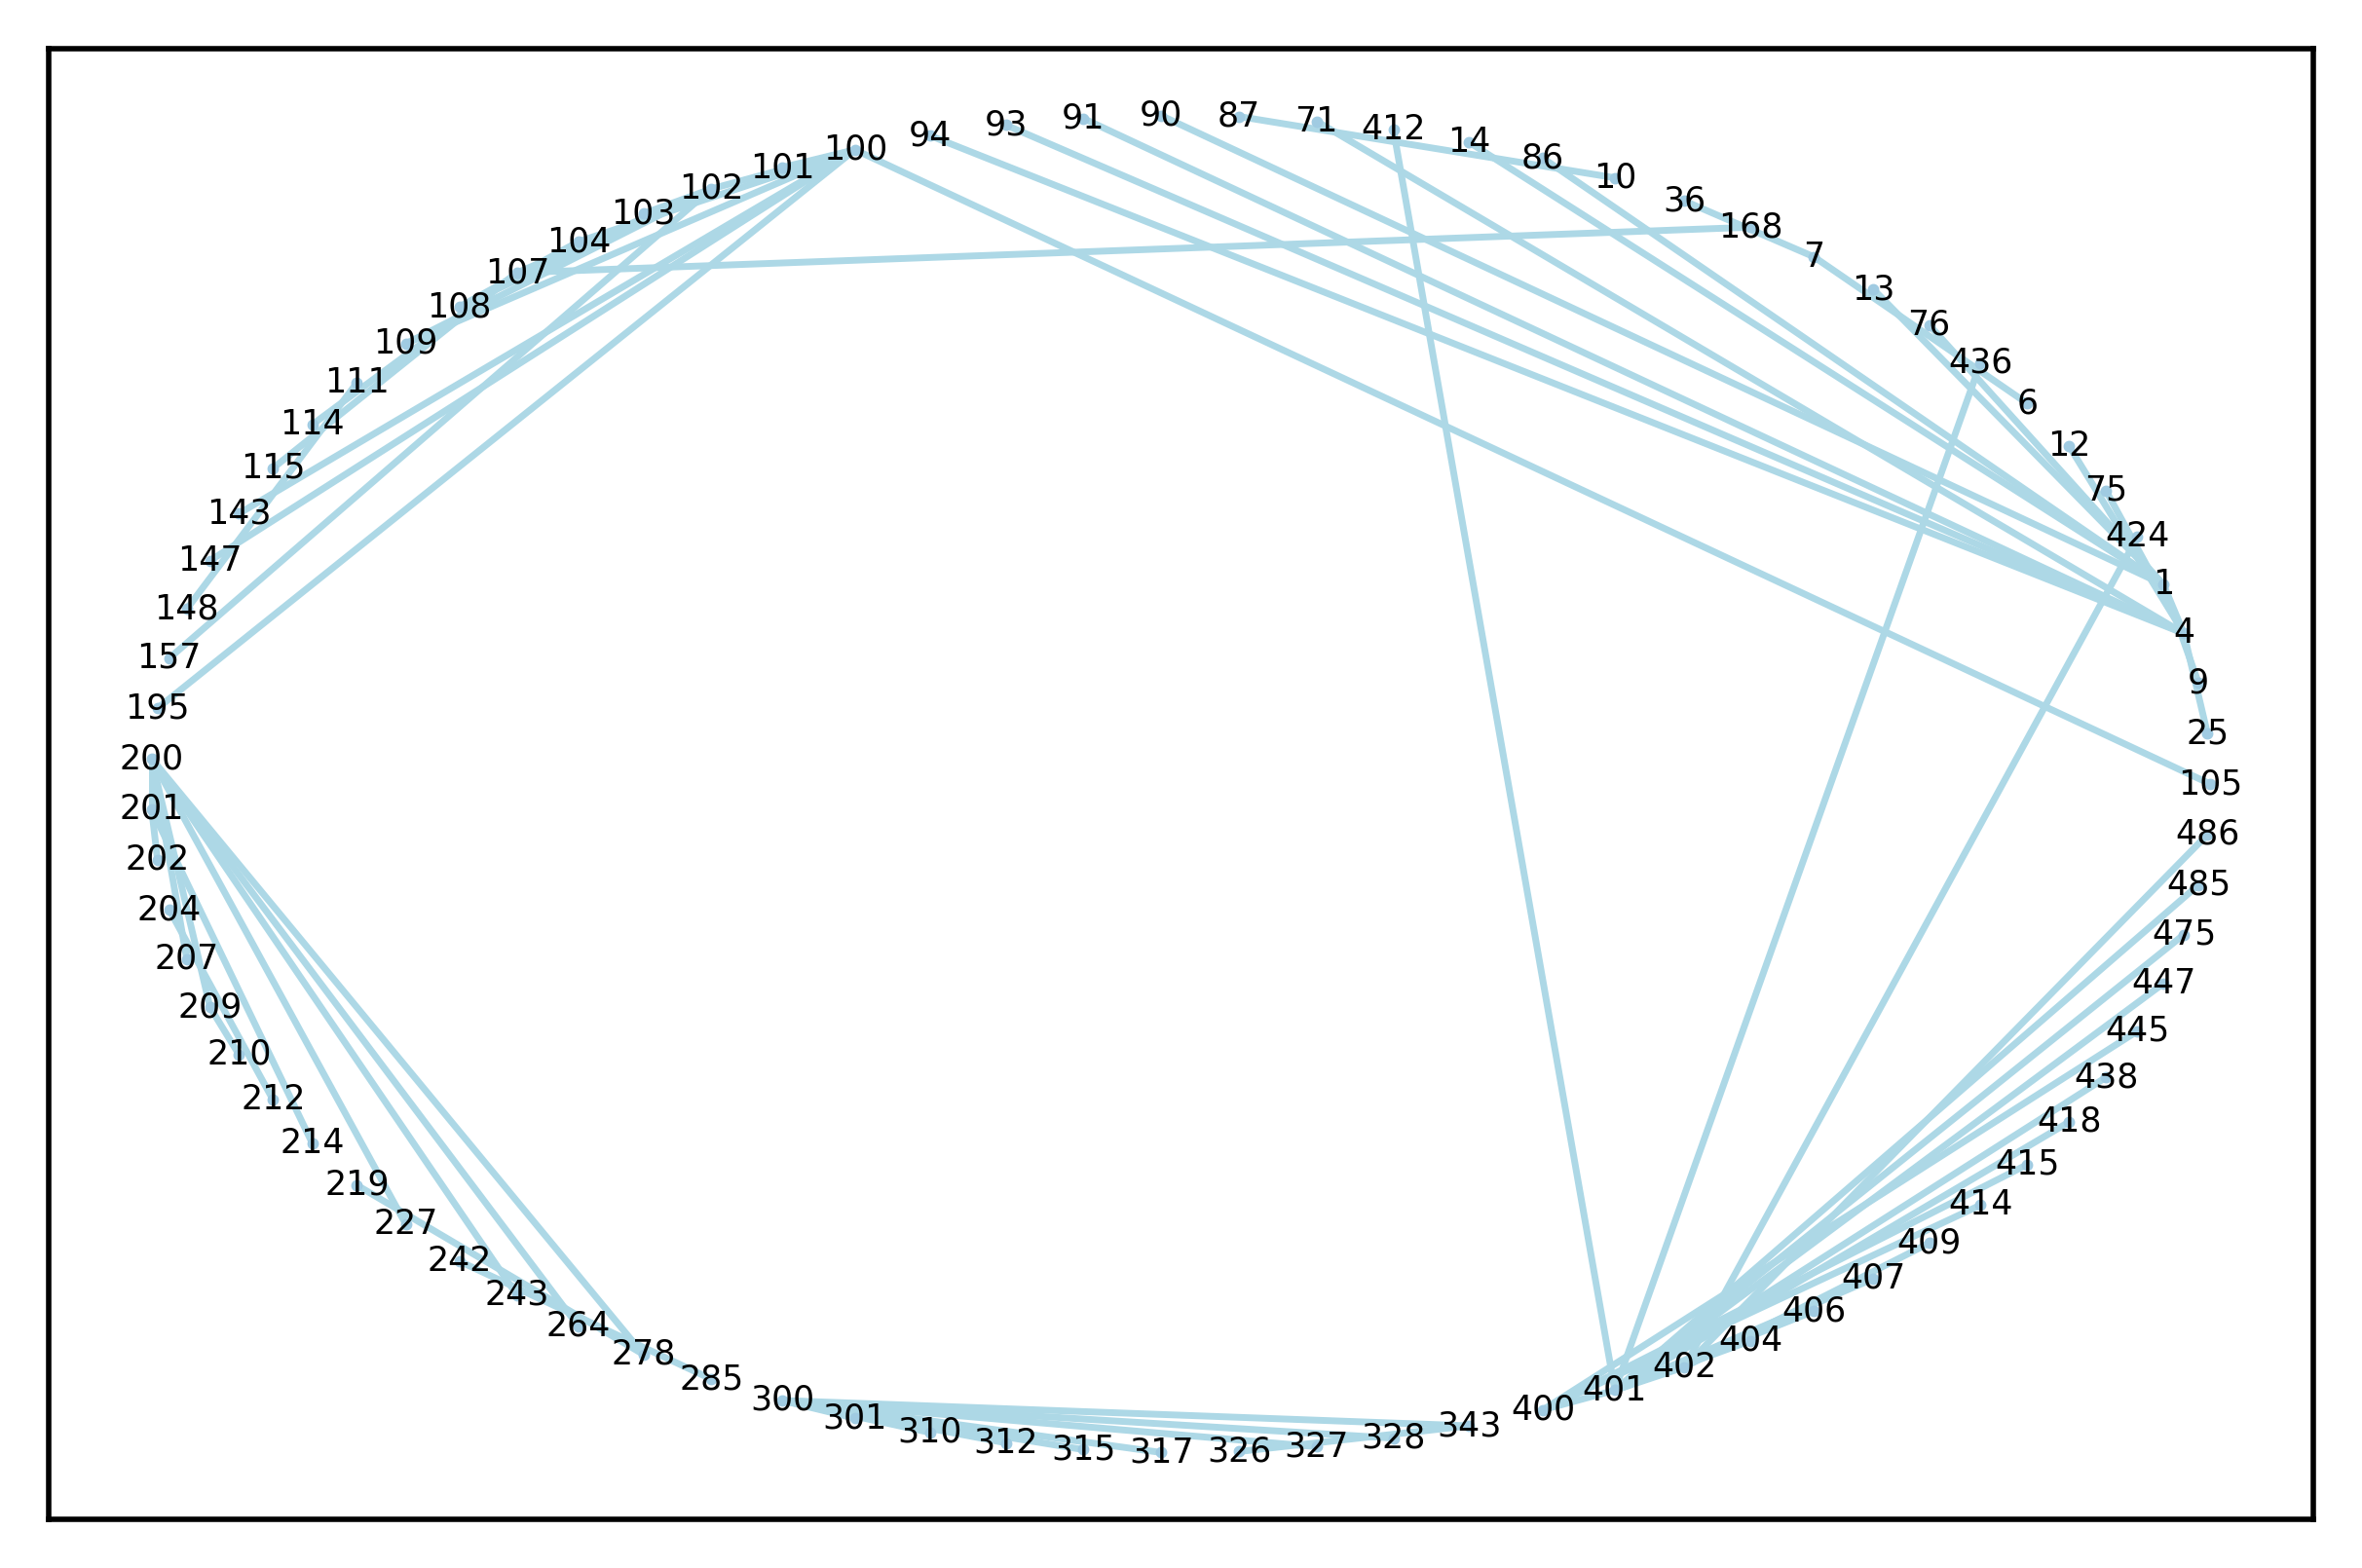

In [7]:
NetworkPlotter(Adjacency_all, which = 3)

#### Plot the network shared between pairs of conditions

- Next, we compare the adjacency matrices between a pair of conditions $(k,k')$ and visualize it in form of a network. 

- We will use our function, "PairNetworkPlotter" which takes the list of adjacency matrices, "Adjacency_all" as one of the inputs. The other input is the pair of the conditions, $(k,k')$ which we want to compare. We compare the conditions $k = 1$ and $k' = 3$ below.

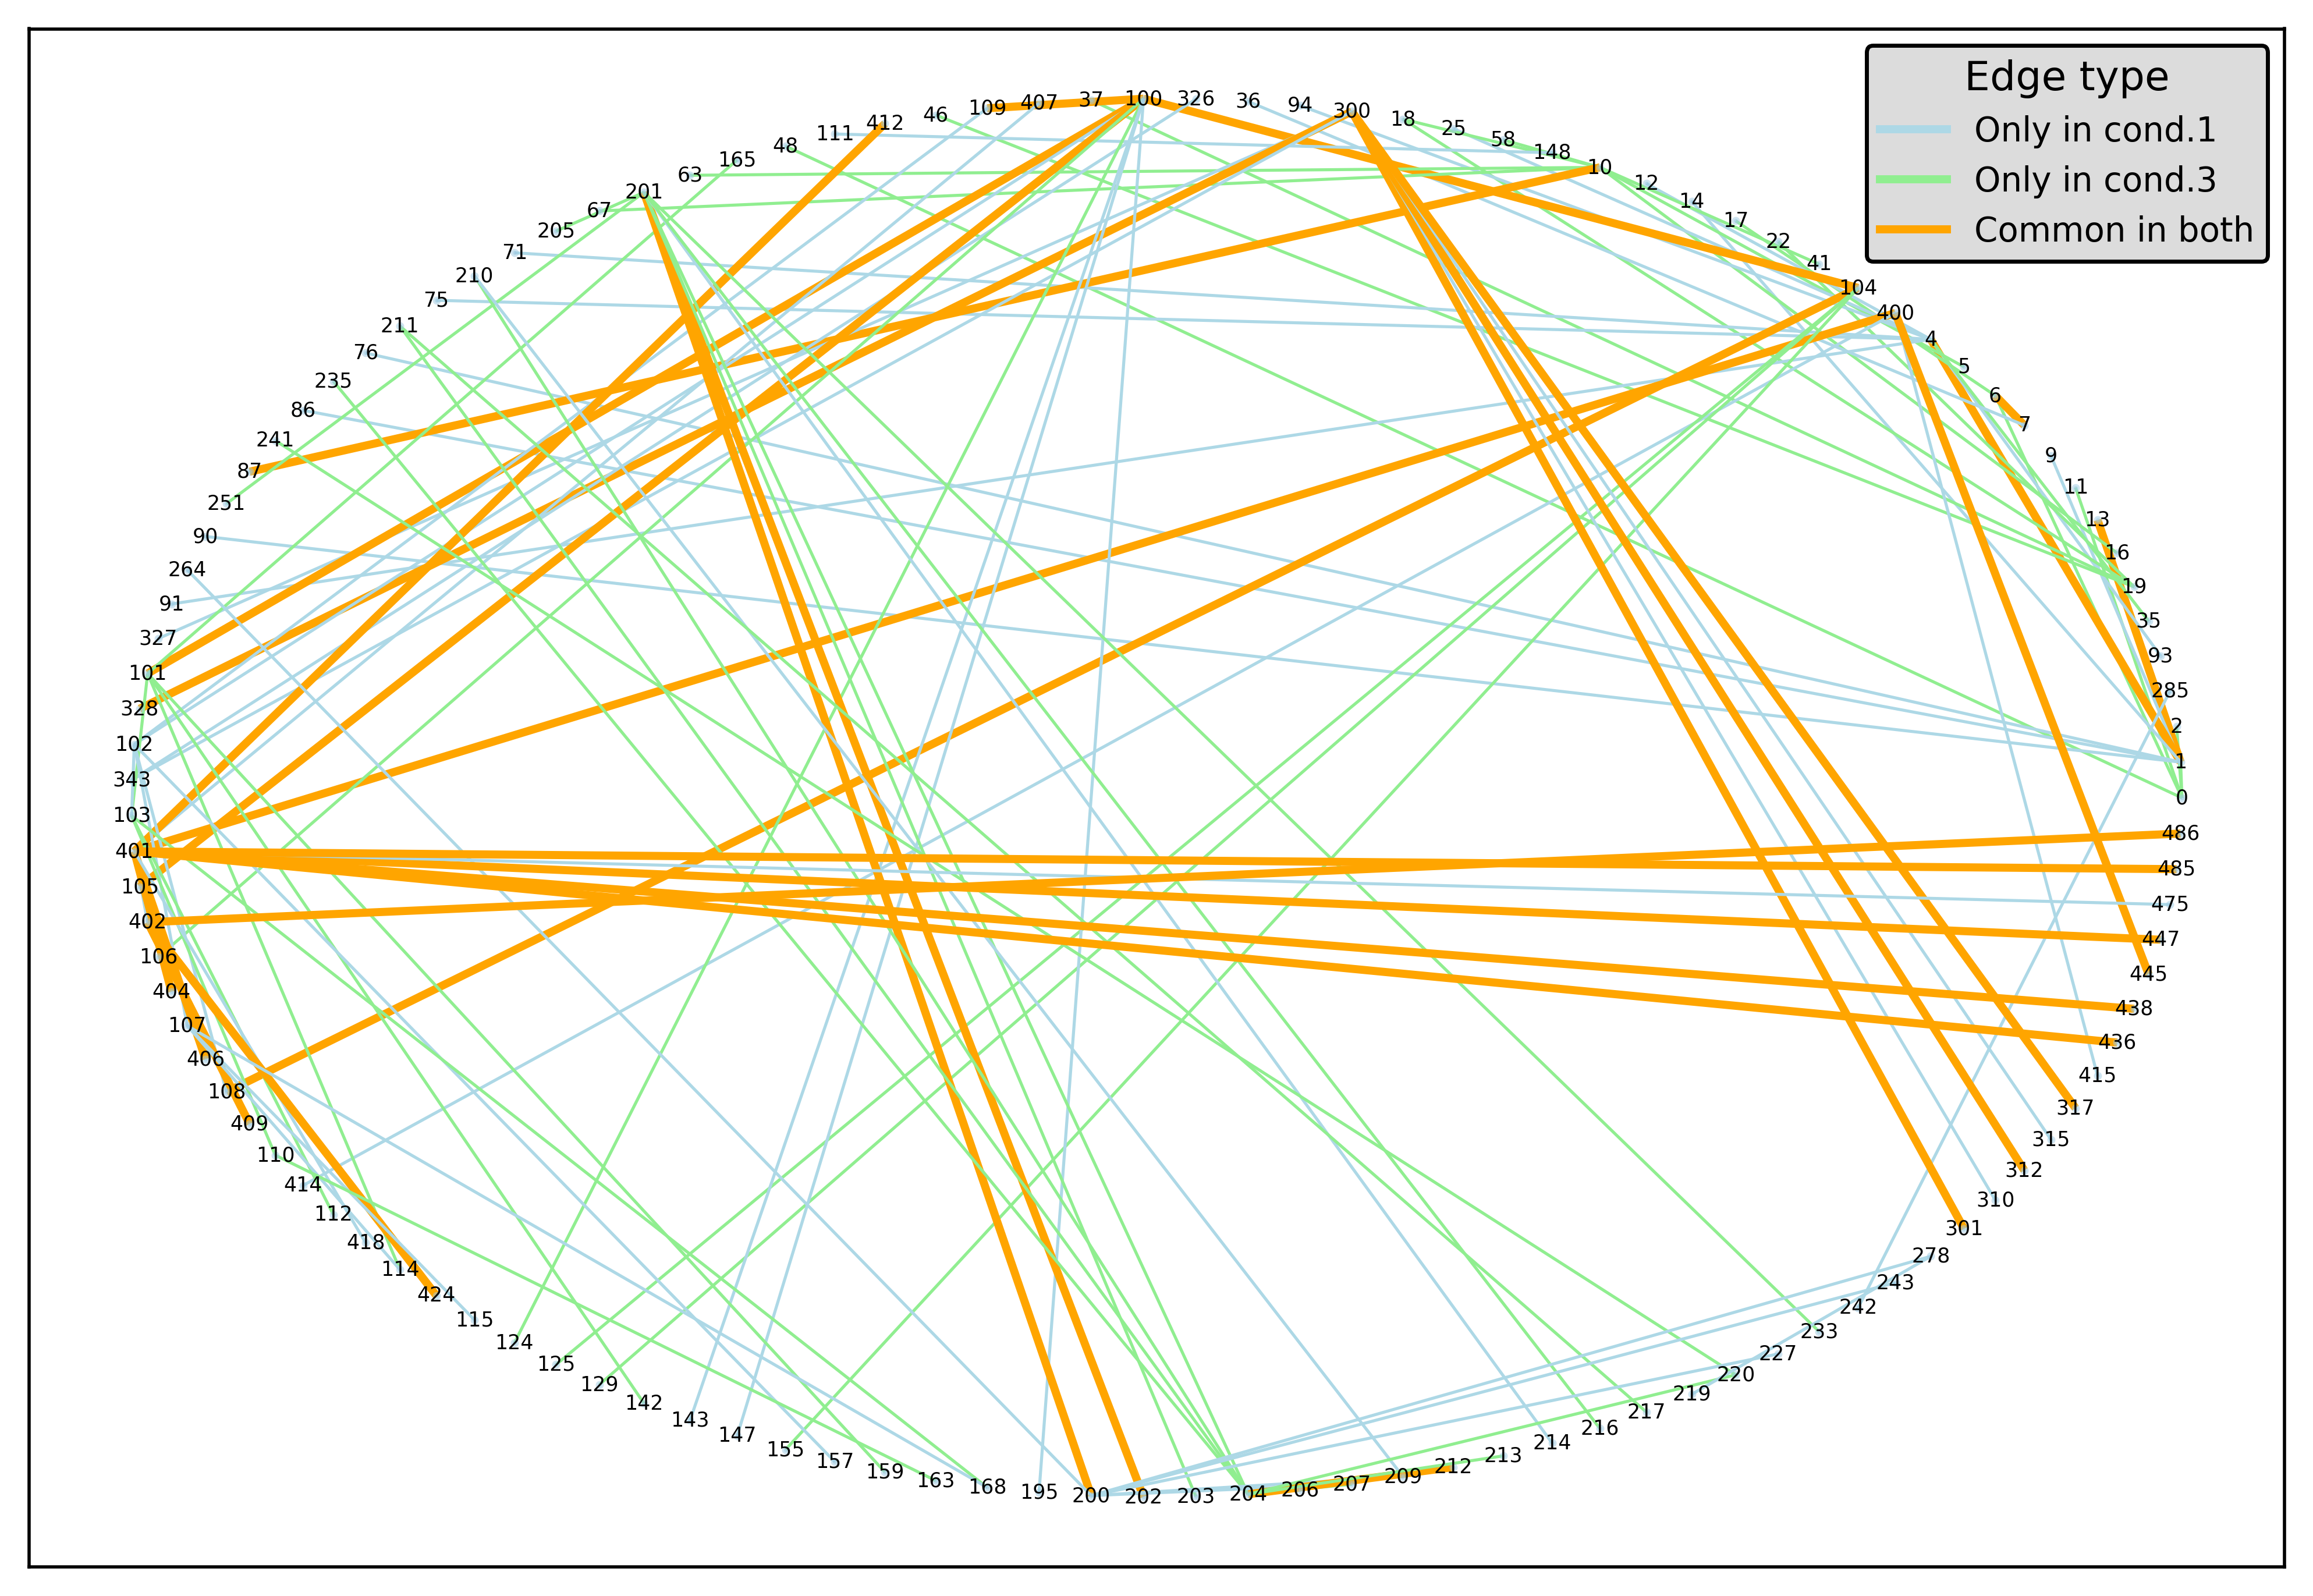

In [8]:
PairNetworkPlotter(Adjacency_all, pair = [1, 3])

The orange edges are the ones which appear both in the condition 1 and 3. The blue and green edges respectively appear only in the condition 1 and 3. 

We compare the conditions $k = 2$ and $k' = 3$ below. In this example dataset, the conditions 1 and 2 had exactly the same networks which is why we see that the pair-wise comparison of top 75 edges between the conditions (1, 3) and (2, 3) look very similar. 

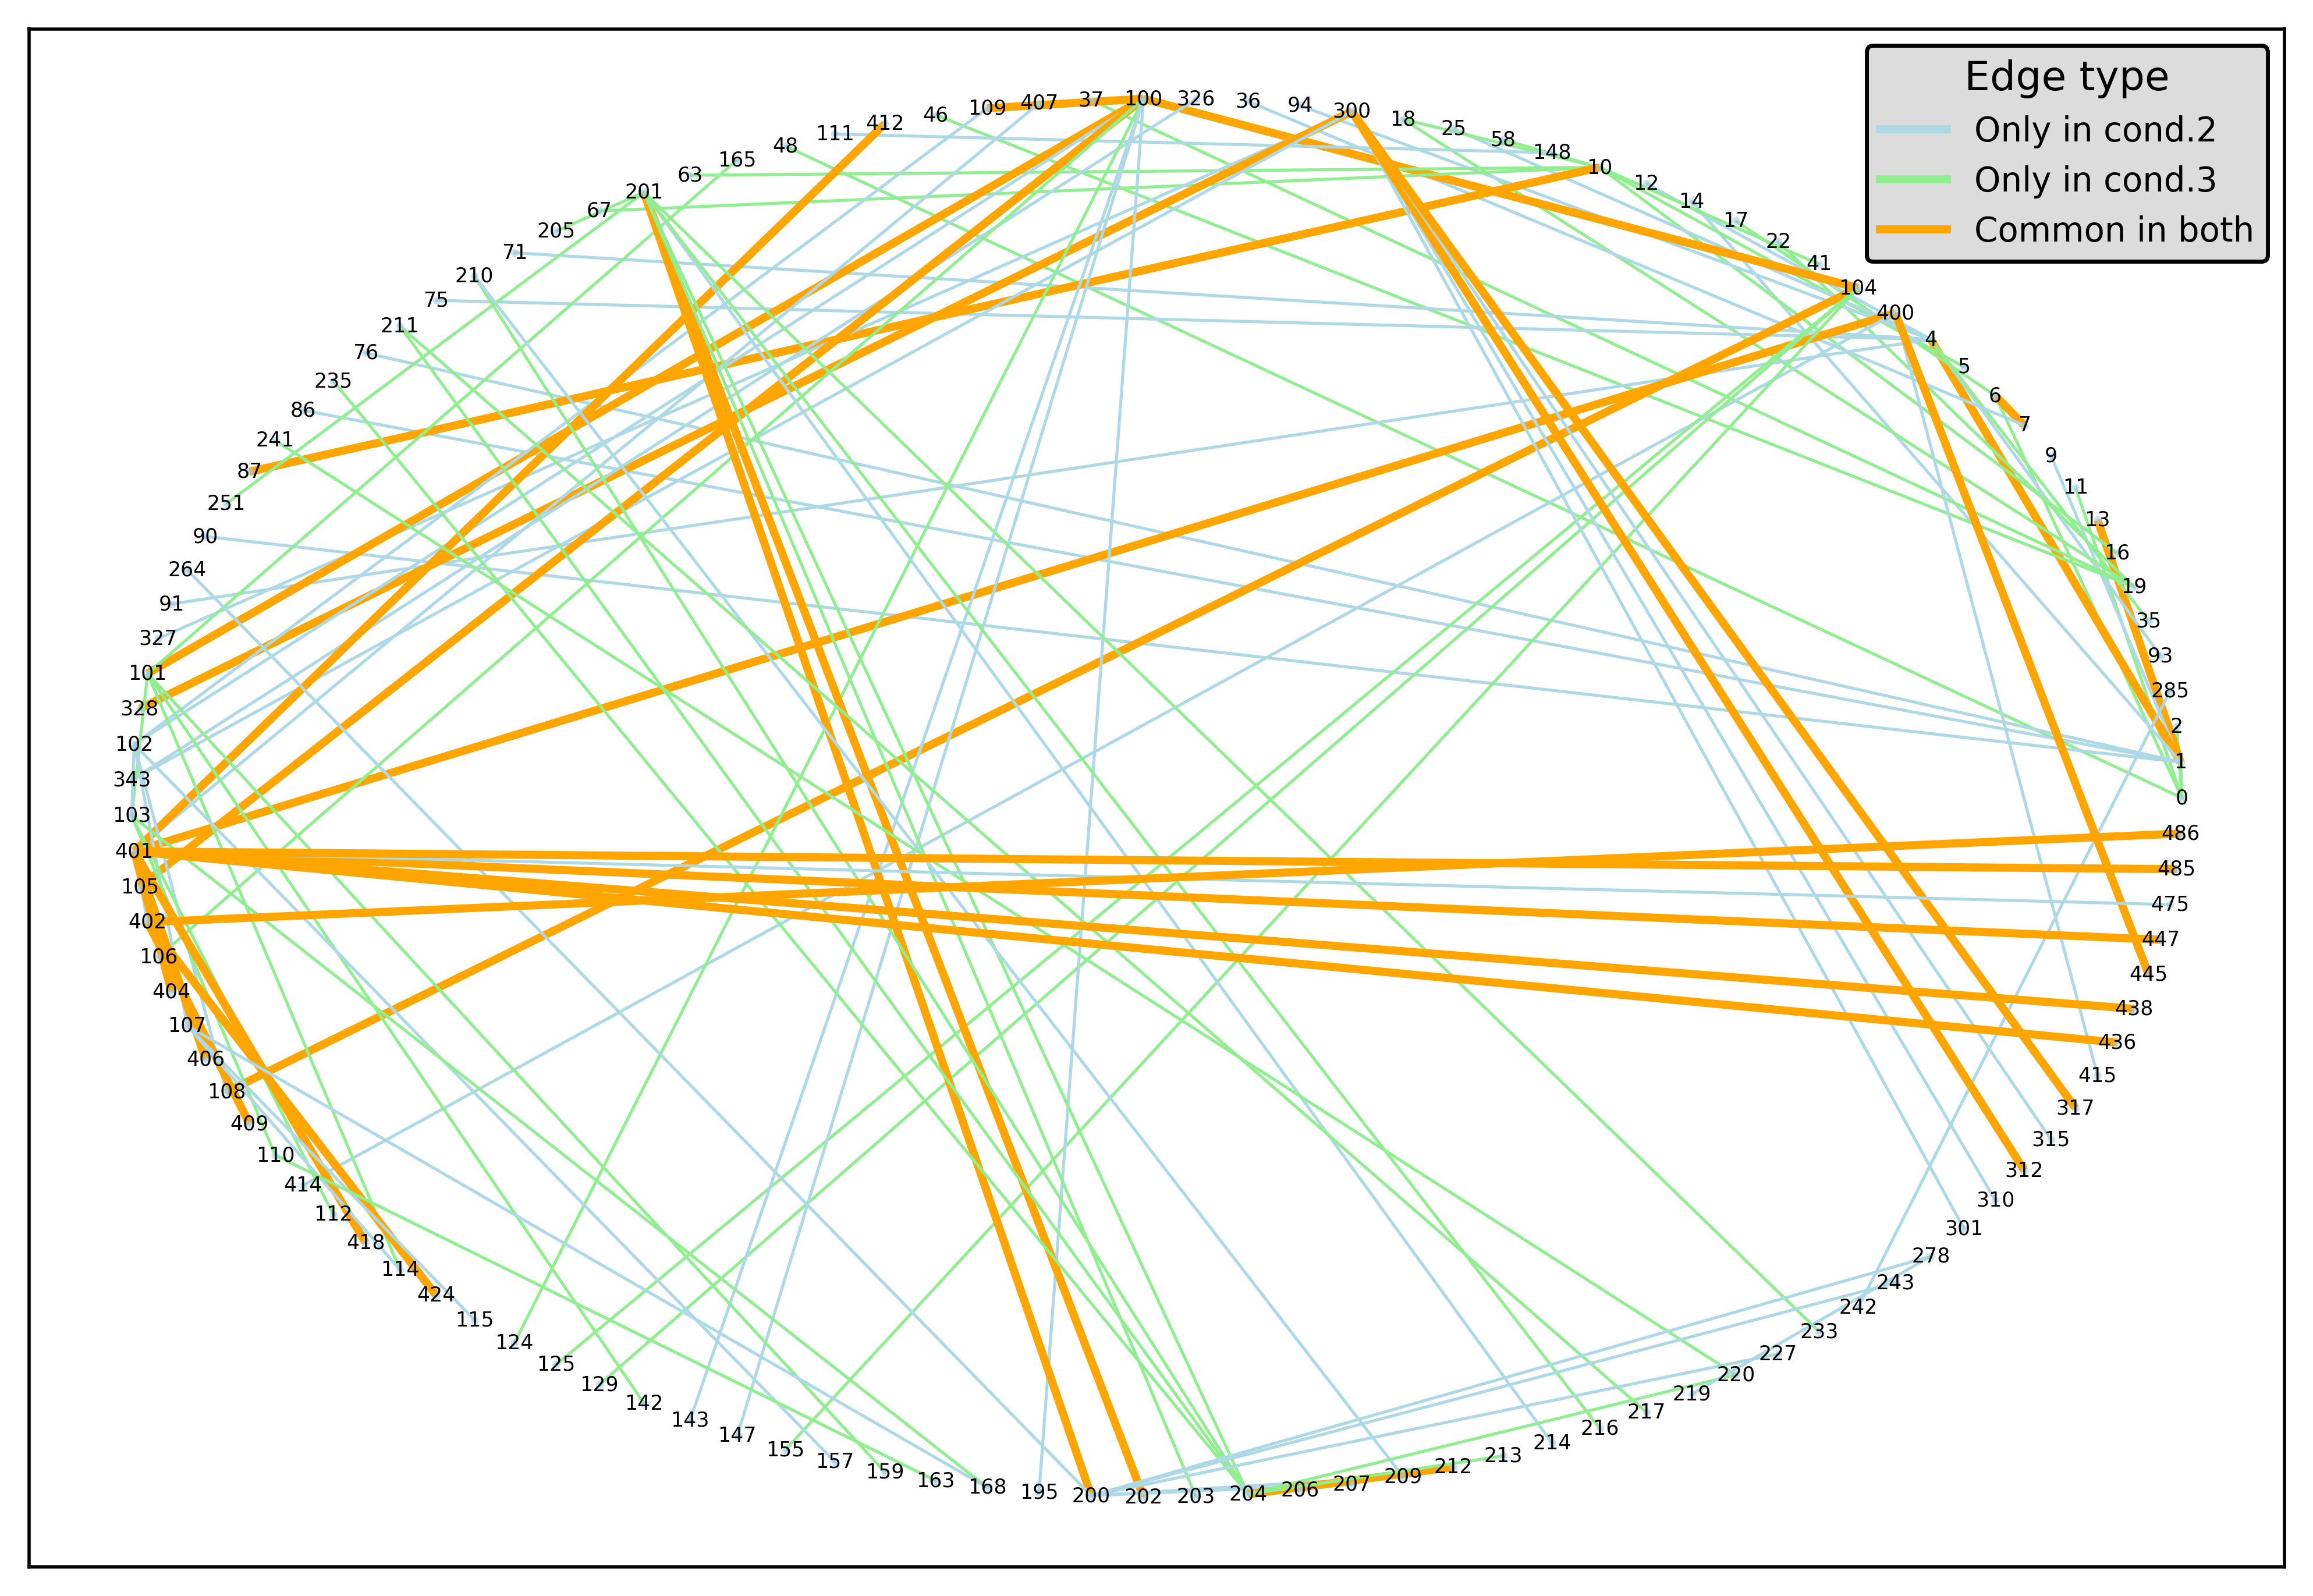

In [9]:
PairNetworkPlotter(Adjacency_all, pair = [2, 3])

#### Plot the network shared across all the conditions

We provide a function named "AllNetworkPlotter" to display the network structure common across all the conditions.
The function takes the list of adjacency matrices, "Adj_all".

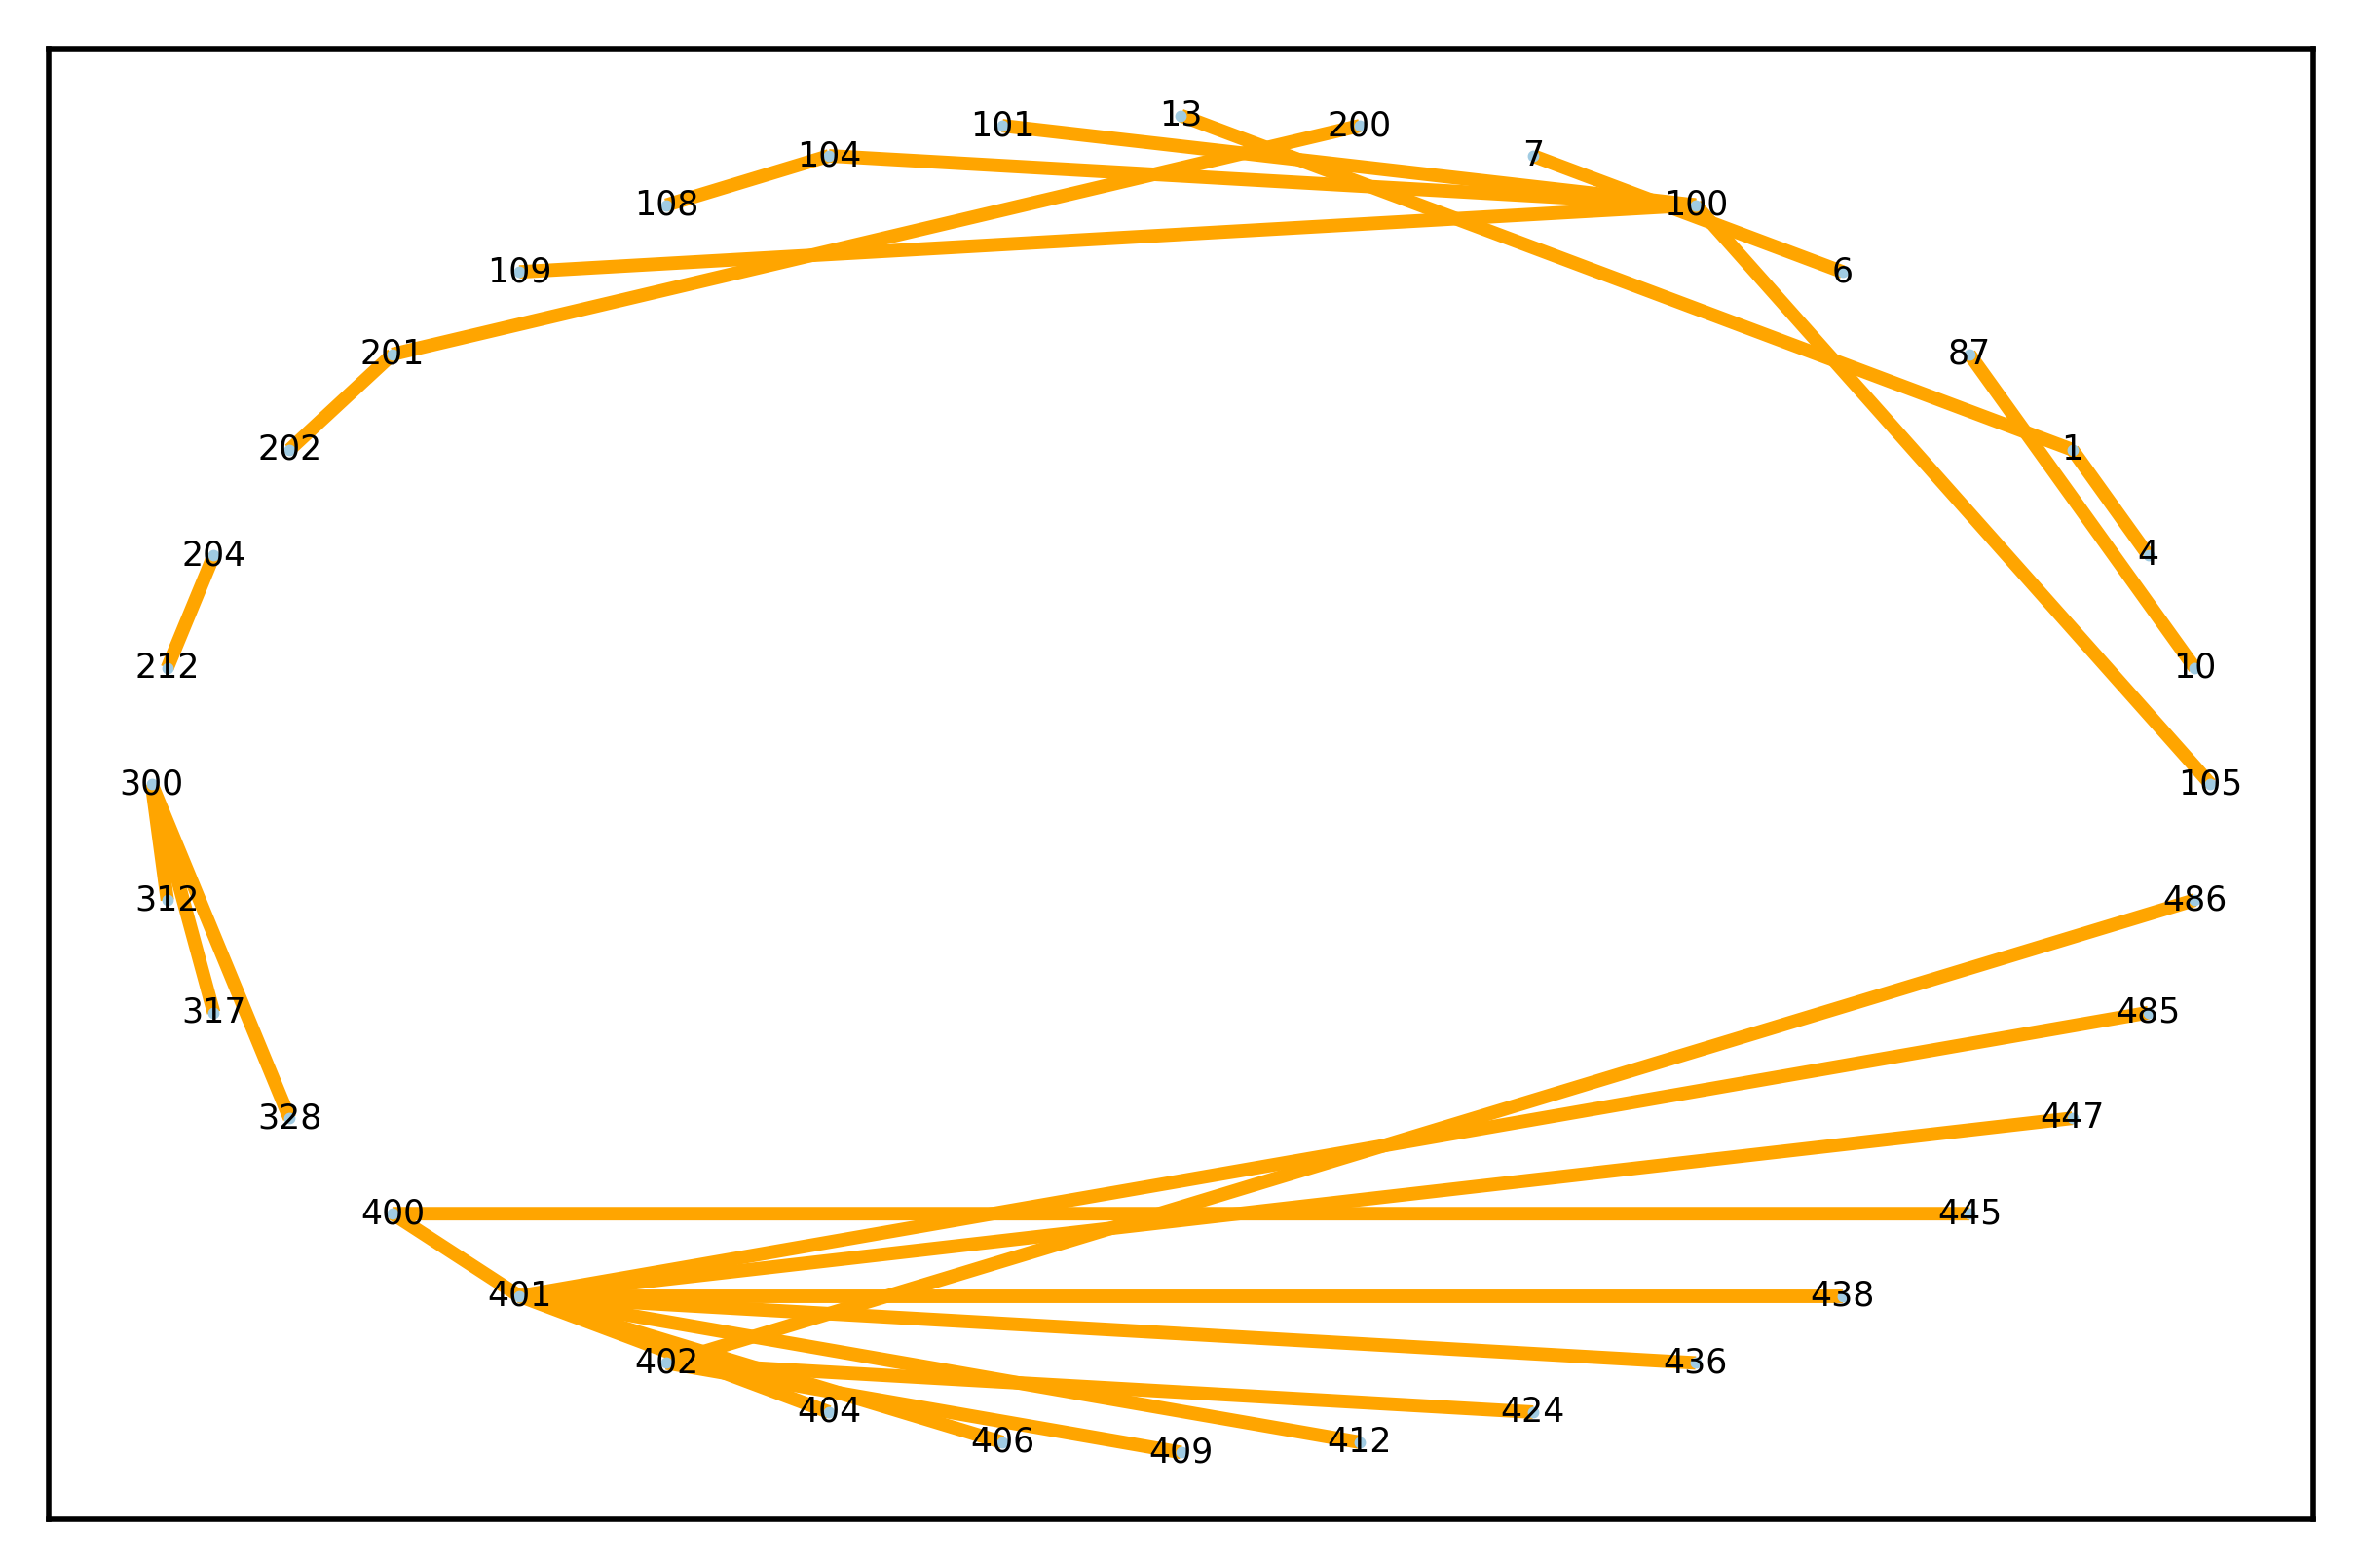

In [11]:
def AllNetworkPlotter(Adjacency_all): 
    all_ind = np.zeros(1)
    num_condn = len(Adjacency_all)
    for k in range(num_condn):
     A21 = Adjacency_all[k]
     all_ind = np.union1d(all_ind, A21.columns)
     if k == 0: 
         int_ind = A21.columns
     else: 
         int_id = np.intersect1d(int_ind, A21.columns)
    
    Adj_all = pd.DataFrame(np.zeros((len(int_id), len(int_id))), 
                           index=int_id, columns=int_id)
    for k in range(len(Adjacency_all)):
     A2 = Adjacency_all[k]
     A2_locs = np.where(np.isin(A2.columns, int_id))[0].tolist()
     Adj_all = Adj_all + A2.iloc[A2_locs, A2_locs]
    
    Adj_all = Adj_all.replace(num_condn-1, 0); Adj_all = Adj_all.replace(num_condn-2, 0)
    Adj_all = Adj_all.loc[(Adj_all.sum(axis=1) != 0), (Adj_all.sum(axis=0) != 0)]
    plt.rcParams['figure.dpi'] = 500
    G = nx.from_pandas_adjacency(Adj_all)
    pos = nx.circular_layout(G)
    
    options = {
       "node_color": "#A0CBE2",
       "edge_color": "orange",
       "width": 2,
       "with_labels": True,
       "font_size" : 5,
       "node_size" : 0.5,
    }
    nx.draw_networkx(G, pos, **options)    
    plt.show()
AllNetworkPlotter(Adjacency_all)

#### Comparison of the conditions in terms of the proportion of common edges

We provide a function named "SummaryTable" that outputs the proportion of edges that are common between every pair of conditions, $(k, k')$ for $k \ne k'$. In the output, 'Pair' corresponds to the pair $(k, k')$ in consideration and 'Prop.' corresponds to the proportion, $\frac{\text{Number of edges that appear both in $k$ and $k'$}}{\text{Number of edges that appear in $k$}}$, and '# edges' corresponds to the number of edges the condition $k$ have.

We compare all the edges across different pairs of conditions, detected at a threshold of 0.005 (i.e., truncation_value = 0.005, top_N = 'all') below. 

In [ ]:
Adj_all_new = MakeAdjMatrix_all(RCFGL_output, truncation_value = 0.005, top_N = 'all')
SummaryTable(Adj_all_new)

We notice that out of 485 edges detected in the condition 1, 99.6% also appear in the condition 2. Similarly, out of 492 edges detected in the condition 3, 82.3% appear both in the conditions 1 and 2.